In [1]:
from aim2dat.aiida_workflows.workflow_builder import WorkflowBuilder
import aiida

aiida.load_profile("tests")
wf_builder = WorkflowBuilder()

## The workflow protocol

The workflow protocols consists of three different sections:

* _tasks_: Is a dictionary containing the details and dependencies for the tasks that can be run with the current workflow.
* _general_input_: defines the preset parameters shared by all work chains.
* _user_input_: defines input parameters that are set by the user.

All predefined protocols are found in the folder: "aim2dat/aim2dat/aiida_workflows/protocols/".
The workflow protocols support versions, which the suffix `"_v*.*"` (* denotes an integer number) a specific protocol version can be chosen.
If the suffix is omitted the latest protocol version is chosen.
At the moment the following protocols are implemented:

| Protocol                            | Latest version | Description                    |
| ----------------------------------- | -------------- | ------------------------------ |
| _arithmetic-testing_                | v1.1           | Protocol for testing purposes. |
| _seekpath-standard_                 | v1.0           | Protocol for a seek-path analysis. |
| _cp2k-crystal-mofs_                 | v2.0           | Protocol to run DFT calculations on MOFs using CP2K. |
| _cp2k-crystal-preopt_               | v3.1           | Protocol to pre-optimize inorganic crystals with loose parameters using CP2K. |
| _cp2k-crystal-standard_             | v3.2           | Standard protocol to run DFT calculations on inorganic crystals using CP2K (<a href="https://doi.org/10.1063/5.0082710" target="_blank">doi:10.1063/5.0082710</a>). |
| _cp2k-crystal-standard-keep-angles_ | v1.1           | Standard protocol for inorganic crystals but constraining lattice parameters. |
| _cp2k-surface-standard_             | v1.0           | Protocol to run the surface workflow using CP2K. |
| _cp2k-crystal-testing_              | v2.0           | Protocol to test the workflow for inorganic crystals with loose parameters using CP2K. |
| _cp2k-surface-testing_              | v1.0           | Protocol to test the surface workflow with loose parameters using CP2K. |

In [2]:
wf_builder.protocol = "arithmetic-testing"

In [3]:
wf_builder.tasks

{'task_1.1': {'dependencies': {}, 'process': 'core.arithmetic.add_multiply'},
 'task_1.2': {'dependencies': {}, 'process': 'core.arithmetic.add_multiply'},
 'task_1.3': {'dependencies': {}, 'process': 'core.arithmetic.add_multiply'},
 'task_2.1': {'dependencies': {'task_1.2': [['result', 'x']],
   'task_1.3': [['result', 'z']]},
  'process': 'core.arithmetic.add_multiply'},
 'task_2.2': {'dependencies': {'task_1.3': [['result', 'y']]},
  'process': 'core.arithmetic.add_multiply'},
 'task_3.1': {'dependencies': {'task_1.1': [['result', 'x']],
   'task_2.1': [['result', 'y']],
   'task_2.2': [['result', 'z']]},
  'process': 'core.arithmetic.add_multiply'},
 'task_4.1': {'dependencies': {'task_3.1': [['result', 'x']],
   'task_1.2': [['result', 'z']]},
  'process': 'core.arithmetic.add_multiply'}}

## Setting up the input parameters and parent node

The provenance of the workflow is defined via the parent node, it is input for all initial tasks of the workflow.
Here, we create a new aiida node without history and pass it to the builder-object:

In [4]:
from aiida.plugins import DataFactory

Float = DataFactory("core.float")
parent_node = Float(4)

wf_builder.parent_node = parent_node

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/aiida/plugins/entry_point.py:349: AiidaDeprecationWarning: The entry point `float` is deprecated. Please replace it with `core.float`. (this will be removed in v3)
  warn_deprecation(f'The entry point `{name}` is deprecated. Please replace it with `core.{name}`.', version=3)


And we can set additional input-parameters (parameters can be given as python types or AiiDA nodes). A dash and subsequent greater than sign (_->_) highlight an individual input parameter defined for just one task of the workflow.

In [5]:
wf_builder.set_user_input("y", 5)
wf_builder.set_user_input("y->task_4.1", 11.0)

In [6]:
wf_builder.determine_workflow_state()

{'next_possible_tasks': ['task_1.1', 'task_1.2', 'task_1.3'],
 'completed_tasks': [],
 'running_tasks': [],
 'failed_tasks': []}

The builder checks whether any work chains with matching input parameters have been performed on the structure. In this case there are no processes run that conform the workflow protocol.

## Executing workflow tasks

The input for the initial task can be created using the 'builder'-method of the AiiDA work chain or calculation or a dictionary of input-parameters for AiiDA calcfunctions:

In [7]:
from aiida.engine import run

wc_builder = wf_builder.generate_inputs("task_1.1")
result = run(**wc_builder)

If we check the workflow again, we see that the task 'task_1.1' is accomplished and we can continue with the next task:

In [8]:
wf_builder.determine_workflow_state()

{'next_possible_tasks': ['task_1.2', 'task_1.3'],
 'completed_tasks': ['task_1.1'],
 'running_tasks': [],
 'failed_tasks': []}

Alternatively, we can run or submit the task straightaway using the methods :meth:`run_task <aim2dat.aiida_workflows.workflow_builder.WorkflowBuilder.run_task>` or :meth:`submit_task <aim2dat.aiida_workflows.workflow_builder.WorkflowBuilder.submit_task>`.
The difference between the two methods is that the first uses AiiDA's `run` method which starts the process in the foreground and blocks the interface while the latter uses AiiDA's `submit` method which passes the process to the daemon that is running in the background.

In [9]:
wf_builder.run_task("task_1.2")
wf_builder.run_task("task_1.3")
wf_builder.run_task("task_2.1")

(<WorkFunctionNode: uuid: 872b6d30-cc56-4cc0-85d4-09d56d3a2871 (pk: 21) (aiida.workflows:core.arithmetic.add_multiply)>,
 <Float: uuid: 9836b302-c3a4-4e7c-91ea-c7dd08d1d638 (pk: 25) value: 2460.0>)

## Visualizing the provenance graph of the workflow

Using the AiiDA built-in features the provenance graph of the workflow can be plotted:

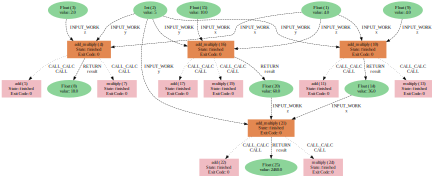

In [10]:
wf_builder.graph_attributes = {"graph_attr": {"size": "6!,6"}}
graph = wf_builder.generate_provenance_graph()
graph.graphviz

In [11]:
from aim2dat.aiida_workflows.workflow_builder import MultipleWorkflowBuilder

mwf_builder = MultipleWorkflowBuilder()
mwf_builder.protocol = "arithmetic-testing"

for n in range(0, 5):
    mwf_builder.add_parent_node(Float(n))

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/aiida/plugins/entry_point.py:349: AiidaDeprecationWarning: The entry point `float` is deprecated. Please replace it with `core.float`. (this will be removed in v3)
  warn_deprecation(f'The entry point `{name}` is deprecated. Please replace it with `core.{name}`.', version=3)


In [12]:
mwf_builder.set_user_input("y", 2.0)
mwf_builder.set_user_input("y->task_4.1", 3.0)

The status information as well as process nodes and workflow results is therefore given as pandas dataframes:

In [13]:
mwf_builder.return_workflow_states()

,task_1.1,task_1.2,task_1.3,task_2.1,task_2.2,task_3.1,task_4.1
0,deps. met,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
1,deps. met,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
2,deps. met,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
3,deps. met,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
4,deps. met,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.


Different tasks can be started for all `parent-nodes` within one function call via the :meth:`run_task <aim2dat.aiida_workflows.workflow_builder.MultipleWorkflowBuilder.run_task>` or :meth:`submit_task <aim2dat.aiida_workflows.workflow_builder.MultipleWorkflowBuilder.submit_task>` functions:

In [14]:
mwf_builder.run_task("task_1.1")
mwf_builder.return_workflow_states()

,parent_node,task_1.1,task_1.2,task_1.3,task_2.1,task_2.2,task_3.1,task_4.1
0,26,completed,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
1,34,completed,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
2,41,completed,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
3,48,completed,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
4,55,completed,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.


The tasks can be started for a subset of the _parent-nodes_ by using the ``interval`` parameter:

In [15]:
mwf_builder.run_task("task_1.2", interval=[0, 3])
mwf_builder.return_workflow_states()

,parent_node,task_1.1,task_1.2,task_1.3,task_2.1,task_2.2,task_3.1,task_4.1
0,26,completed,completed,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
1,34,completed,completed,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
2,41,completed,completed,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
3,48,completed,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.
4,55,completed,deps. met,deps. met,missing deps.,missing deps.,missing deps.,missing deps.


Several tasks can be started consecutively by setting a task queue:

In [16]:
mwf_builder.add_to_task_queue("task_1.2", run_type="run")
mwf_builder.add_to_task_queue("task_1.3", run_type="run")
mwf_builder.add_to_task_queue("task_2.1", run_type="run")
mwf_builder.add_to_task_queue("task_2.2", run_type="run")
mwf_builder.add_to_task_queue("task_3.1", run_type="run")
mwf_builder.add_to_task_queue("task_4.1", run_type="run")
mwf_builder.execute_task_queue()

Additional information can be returned via the functions [``return_process_nodes``](aim2dat.aiida_workflows.workflow_builder.MultipleWorkflowBuilder.return_process_nodes) and [``return_results``](aim2dat.aiida_workflows.workflow_builder.MultipleWorkflowBuilder.return_results):

In [17]:
mwf_builder.return_process_nodes()

,parent_node,task_1.1,task_1.2,task_1.3,task_2.1,task_2.2,task_3.1,task_4.1
0,26,29,63,89,114,139,164,190
1,34,36,68,94,119,144,169,195
2,41,43,73,99,124,149,174,200
3,48,50,78,104,129,154,179,205
4,55,57,83,109,134,159,184,210


In [18]:
mwf_builder.return_results()

,parent_node,res_1 (test_unit),res_2 (test_unit)
0,26,24.0,0.0
1,34,54324.0,12.0
2,41,366128.0,24.0
3,48,1251180.0,36.0
4,55,3145032.0,48.0


In [19]:
mwf_builder.to_file("test_workflow.yaml")

mwf_builder2 = MultipleWorkflowBuilder.from_file("test_workflow.yaml")
mwf_builder2.return_workflow_states()

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/aiida/plugins/entry_point.py:349: AiidaDeprecationWarning: The entry point `float` is deprecated. Please replace it with `core.float`. (this will be removed in v3)
  warn_deprecation(f'The entry point `{name}` is deprecated. Please replace it with `core.{name}`.', version=3)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/aiida/plugins/entry_point.py:349: AiidaDeprecationWarning: The entry point `float` is deprecated. Please replace it with `core.float`. (this will be removed in v3)
  warn_deprecation(f'The entry point `{name}` is deprecated. Please replace it with `core.{name}`.', version=3)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/aiida/plugins/entry_point.py:349: AiidaDeprecationWarning: The entry point `float` is deprecated. Please replace it with `core.float`. (this will be removed in v3)
  warn_deprecation(f'The entry point `{name}` is deprecated. Please replace i

,parent_node,task_1.1,task_1.2,task_1.3,task_2.1,task_2.2,task_3.1,task_4.1
0,26,completed,completed,completed,completed,completed,completed,completed
1,34,completed,completed,completed,completed,completed,completed,completed
2,41,completed,completed,completed,completed,completed,completed,completed
3,48,completed,completed,completed,completed,completed,completed,completed
4,55,completed,completed,completed,completed,completed,completed,completed
